In [3]:
IDENTIFIER = "haydn-op1"
NUM = 3

import json
import networkx as nx
import pandas as pd
from dwave.system import DWaveSampler, FixedEmbeddingComposite

from plots import plotCSV
from qubo import createBQM
from samples import totalEntropy


picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))
qa = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [5]:
cs = 25

def recordAnnealTime(annealRange, bqm, filepath: str):
    
    file = pd.DataFrame()
    reads = 500

    for a in annealRange:
        sampleset = qa.sample(bqm, num_reads=reads, chain_strength=cs, annealing_time=a, label=f"{IDENTIFIER}_{NUM}_at={a}")
        sample = sampleset.first

        new_row = pd.DataFrame({
            "Anneal time": [sampleset.info["timing"]["qpu_anneal_time_per_sample"]],
            "QPU time": [sampleset.info["timing"]["qpu_sampling_time"]],
            "Chain strength": [cs],
            "Total reads": [reads],
            "Chain break fraction": [sample.chain_break_fraction],
            "Lowest energy": [bqm.energy(sample.sample)],
            "Total entropy": [totalEntropy(sample.sample, G)]
            })
    
        print(f"Anneal time {a} us recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)

# 10–300 repeated 3 times
annealTimes = range(10,310,10)
bqm = createBQM(G, phrases, instruments, 6, 6)

for _ in range(2):
    recordAnnealTime(annealTimes, bqm, dataPath+"anneal-time.csv")

Anneal time 10 us recorded!
Anneal time 20 us recorded!
Anneal time 30 us recorded!
Anneal time 40 us recorded!
Anneal time 50 us recorded!
Anneal time 60 us recorded!
Anneal time 70 us recorded!
Anneal time 80 us recorded!
Anneal time 90 us recorded!
Anneal time 100 us recorded!
Anneal time 110 us recorded!
Anneal time 120 us recorded!
Anneal time 130 us recorded!
Anneal time 140 us recorded!
Anneal time 150 us recorded!
Anneal time 160 us recorded!
Anneal time 170 us recorded!
Anneal time 180 us recorded!
Anneal time 190 us recorded!
Anneal time 200 us recorded!
Anneal time 210 us recorded!
Anneal time 220 us recorded!
Anneal time 230 us recorded!
Anneal time 240 us recorded!
Anneal time 250 us recorded!
Anneal time 260 us recorded!
Anneal time 270 us recorded!
Anneal time 280 us recorded!
Anneal time 290 us recorded!
Anneal time 300 us recorded!
Anneal time 10 us recorded!
Anneal time 20 us recorded!
Anneal time 30 us recorded!
Anneal time 40 us recorded!
Anneal time 50 us recorded!

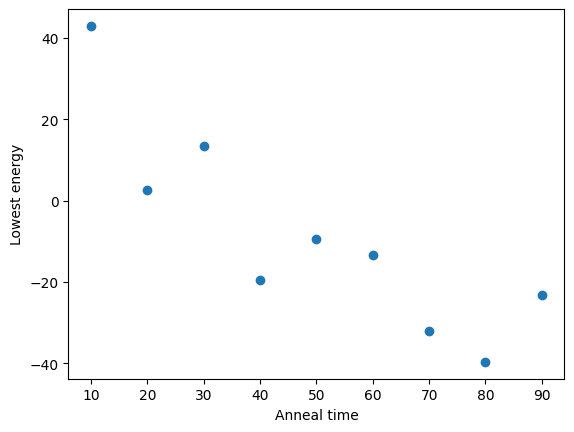

In [8]:
plotCSV(dataPath+"anneal-time.csv", "Anneal time", "Lowest energy", "tab:blue")

# ~200us optimal???